In [1]:
import os
import torch
from torch.utils.data import Dataset

from transformers import ViTModel
from transformers import ViTImageProcessor

import imageio

class KTHDataset(Dataset):
    def __init__(self, root_dir, N):
        '''
        root_dir: directory of the dataset
        N: number of past frames
        '''
        self.root_dir = root_dir
        self.N = N
        self.samples = []

        # Iterate through each category folder and collect video paths
        for category in os.listdir(root_dir):
            category_folder = os.path.join(root_dir, category)
            if os.path.isdir(category_folder):
                for video_file in os.listdir(category_folder):
                    video_path = os.path.join(category_folder, video_file)
                    # Get the total number of frames of the current video
                    num_frames = self.get_total_frames(video_path)
                    # Add each possible sequence in this video
                    for i in range(num_frames - N):
                        self.samples.append((video_path, i))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        video_path, start_frame = self.samples[idx]

        # Get N+1 frames of the video_path, starting from the "start_frame" index
        frames = self.read_frames(video_path, start_frame, self.N + 1)

        # Process each frame to have the shape [channels, width, height]
        processed_frames = [self.process_frame(frame) for frame in frames]

        # Stack N frames for input data
        data = torch.stack(processed_frames[:-1])   # data = [N, channels, width, height]

        # Output data (label) is the ViT processed features of the last frame
        last_frame = processed_frames[-1]                # label = [channels, width, height]
        model_name = 'google/vit-base-patch16-224'
        model = ViTModel.from_pretrained(model_name)
        processor = ViTImageProcessor.from_pretrained(model_name)
        inputs = processor(images=last_frame, return_tensors='pt')
        pixel_values = inputs.pixel_values 
        with torch.no_grad():
            label = model(pixel_values)
            label = label.last_hidden_state.squeeze()    # label = [197, d_model]

        return data, label

    def read_frames(self, video_path, start_frame, num_frames):
        frames = []
        try:
            reader = imageio.get_reader(video_path)

            # Skipping to the start frame
            for _ in range(start_frame):
                _ = reader.get_next_data()

            # Reading the required number of frames
            for _ in range(num_frames):
                frame = reader.get_next_data()
                frames.append(frame)

        except Exception as e:
            print(f"Error reading frames from {video_path}: {e}")

        return frames
    
    def get_total_frames(self, video_path):
        num_frames = 0
        try:
            reader = imageio.get_reader(video_path)
            for _ in reader:
                num_frames += 1
        except Exception as e:
            print(f"Error counting frames in video file {video_path}: {e}")

        return num_frames
    
    def process_frame(self, frame):
        '''
        Process a frame to have the shape of [channels, width, height]
        Args:
            frame: the frame to be processed
        '''
        # Convert the frame to a PyTorch tensor
        frame_tensor = torch.from_numpy(frame)

        # The frame is originally in (H, W, C) format => convert to (C, W, H)
        frame_tensor = frame_tensor.permute(2, 0, 1)

        return frame_tensor

/Users/hynguyen/opt/anaconda3/envs/torch-gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Testing scripts

In [2]:
root_dir = './dataset'
video_path = './dataset/running/person11_running_d1_uncomp.avi'

Test read_frames() method:

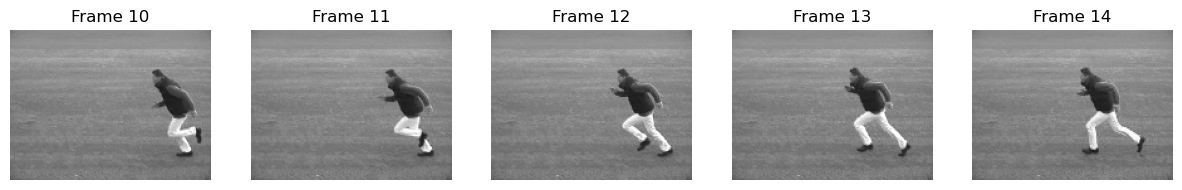

In [4]:
import matplotlib.pyplot as plt
import imageio

# Path to your test video
video_path = './dataset/running/person11_running_d1_uncomp.avi'

# Test parameters: adjust these to your needs
start_frame = 10
num_frames = 5

# Call the function
def read_frames(video_path, start_frame, num_frames):
    frames = []
    try:
        reader = imageio.get_reader(video_path)

        # Skipping to the start frame
        for _ in range(start_frame):
            _ = reader.get_next_data()

        # Reading the required number of frames
        for _ in range(num_frames):
            frame = reader.get_next_data()
            frames.append(frame)

    except Exception as e:
        print(f"Error reading frames from {video_path}: {e}")

    return frames
frames = read_frames(video_path, start_frame, num_frames)

# Plot the frames
fig, axs = plt.subplots(1, len(frames), figsize=(15, 5))
for i, frame in enumerate(frames):
    if len(frames) > 1:
        axs[i].imshow(frame)
        axs[i].set_title(f"Frame {start_frame + i}")
        axs[i].axis('off')
    else:
        plt.imshow(frame)
        plt.title(f"Frame {start_frame + i}")
        plt.axis('off')

plt.show()

Print frame shape:

In [5]:
f = frames[0]
print(f.shape)

(120, 160, 3)


In [6]:
print(type(f))
print(f)

<class 'imageio.core.util.Array'>
[[[142 142 142]
  [144 144 144]
  [147 147 147]
  ...
  [151 151 151]
  [144 144 144]
  [142 142 142]]

 [[115 115 115]
  [118 118 118]
  [124 124 124]
  ...
  [125 125 125]
  [123 123 123]
  [118 118 118]]

 [[121 121 121]
  [121 121 121]
  [121 121 121]
  ...
  [126 126 126]
  [123 123 123]
  [118 118 118]]

 ...

 [[ 95  95  95]
  [ 98  98  98]
  [104 104 104]
  ...
  [ 98  98  98]
  [ 96  96  96]
  [105 105 105]]

 [[ 95  95  95]
  [104 104 104]
  [102 102 102]
  ...
  [103 103 103]
  [ 96  96  96]
  [ 96  96  96]]

 [[ 88  88  88]
  [ 88  88  88]
  [ 95  95  95]
  ...
  [ 83  83  83]
  [ 95  95  95]
  [ 89  89  89]]]


Test KTHDataset class:

In [3]:
N = 5  # Number of past frames
dataset = KTHDataset(root_dir, N)

Error counting frames in video file ./dataset/walking/.DS_Store: Could not find a backend to open `./dataset/walking/.DS_Store`` with iomode `r?`.


In [9]:
data, label = dataset[0]  # Get the first sample for testing

Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
print(data.shape)
print(label.shape)

torch.Size([5, 3, 120, 160])
torch.Size([197, 768])


In [11]:
data_np = data.numpy().transpose(0, 2, 3, 1)  # Shape: [N, height, width, channels]

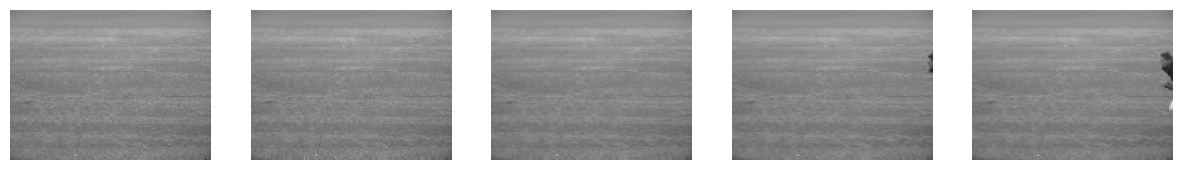

In [12]:
import matplotlib.pyplot as plt


# Visualise data
fig, axes = plt.subplots(1, N, figsize=(15, 8))
for i in range(N):
    axes[i].imshow(data_np[i])
    axes[i].axis('off')